## Section 1. Config

In [260]:
# Configuration
TARGET = "Kepler-5b"  # Change this to your target
MISSION = "Kepler"  # or "TESS"
SIGMA_CLIP = 5.0
DOWNLOAD_ALL = True  # Set to True to download all available files and stitch them

USE_TLS = False
VERBOSE = True
REFINE_DURATION = True
SYSTEMATICS_CORRECTION = "off" # off, cbv, reg, both
INCLUDE_ML_CUTOUTS = False
ACCEPTANCE_FACTOR_FOR_SHORT_MOVES = 0.85

# Eclipse
MASK_ECLIPSES = False
ECLIPSE_NSIGMA = 10.0
ECLIPSE_MIN_DEPTH_ABS = 0.02
ECLIPSE_MIN_GROUP = 6
ECLIPSE_PAD_POINTS = 2
ECLIPSE_MAX_MASK_FRACTION = 0.8


## Section 2. Imports

In [261]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from astropy.timeseries import BoxLeastSquares 
from scipy import stats
from scipy.ndimage import uniform_filter1d
from scipy.stats import binned_statistic
from statsmodels.tsa.stattools import acf as sm_acf
from collections import OrderedDict
from scipy.stats import skew, kurtosis
from scipy.stats import binned_statistic
from concurrent.futures import ProcessPoolExecutor, as_completed
import time
import os
import datetime
import pandas as pd

## Section 3. Processing

In [ ]:
# 1 - Download and clean light curve with systematics correction

def download_and_clean(target, mission="Kepler", sigma_clip=5.0, systematics_correction="off"):
    """
    Download and clean light curve with optional systematics correction.
    
    Parameters:
    -----------
    target : str
        Target identifier
    mission : str
        Mission name (default: "Kepler")
    sigma_clip : float
        Sigma clipping threshold for outlier removal
    systematics_correction : str
        Systematics correction method: "off", "cbv", "reg", or "both"
    """
    lc = lk.search_lightcurve(target, mission=mission).download()
    lc = lc.remove_nans()
    lc = lc.normalize()
    
    # Apply systematics correction if requested
    if systematics_correction in ["cbv", "both"]:
        lc = apply_cbv_correction(lc)
    
    if systematics_correction in ["reg", "both"]:
        lc = apply_regression_correction(lc)
    
    lc = lc.remove_outliers(sigma=sigma_clip)
    return lc

def apply_cbv_correction(lc):
    """Apply CBV (Cotrending Basis Vector) correction to remove Kepler systematics."""
    try:
        print("Applying CBV correction...")
        # Get CBVs for the light curve
        cbvs = lc.correct()
        if cbvs is not None:
            print(f"CBV correction applied successfully")
            return cbvs
        else:
            print("CBV correction failed, returning original light curve")
            return lc
    except Exception as e:
        print(f"CBV correction failed: {e}, returning original light curve")
        return lc

def apply_regression_correction(lc):
    """Apply regression-based correction using design matrix."""
    try:
        print("Applying regression correction...")
        # Create regression corrector
        corrector = lk.RegressionCorrector(lc)
        
        # Add CBVs as regressors if available
        try:
            cbvs = lc.cbv
            if cbvs is not None:
                corrector.correct(cbv=True)
                print("Regression correction with CBVs applied")
                return corrector.corrected_lc
        except:
            pass
        
        # Fallback: try to add motion and quality columns as regressors
        try:
            # Check if motion columns exist
            if hasattr(lc, 'centroid_col') and hasattr(lc, 'centroid_row'):
                corrector.correct(motion=True)
                print("Regression correction with motion applied")
                return corrector.corrected_lc
        except:
            pass
        
        print("Regression correction not possible, returning original light curve")
        return lc
        
    except Exception as e:
        print(f"Regression correction failed: {e}, returning original light curve")
        return lc

# 2 -  Detrend light curve with BLS and mask

def detrend_with_bls_mask(tTime, flux,
                          min_period=0.5, max_period=None,
                          n_periods=2000, n_durations=50,
                          oversample=10,
                          bin_width=0.5, spline_s=0.001,
                          max_iter=4, sigma=3.0,
                          refine_duration=True,
                          use_tls=True,
                          mask_eclipses=True,
                          eclipse_nsigma=ECLIPSE_NSIGMA,
                          eclipse_min_depth_abs=ECLIPSE_MIN_DEPTH_ABS,
                          eclipse_min_group=ECLIPSE_MIN_GROUP,
                          eclipse_pad_points=ECLIPSE_PAD_POINTS,
                          eclipse_max_mask_fraction=ECLIPSE_MAX_MASK_FRACTION):
    bls_start = time.time()
    print("Starting BLS detrending and period search...")
    
    mask_valid = np.isfinite(tTime) & np.isfinite(flux)
    tTime = np.asarray(tTime)[mask_valid]
    flux = np.asarray(flux)[mask_valid]
    # Keep a copy of raw (pre-stitch) flux for eclipse detection
    _flux_raw_for_eclipse = np.asarray(flux).copy()

    # Pre-BLS stitching: per-segment robust normalization and tail winsorization
    try:
        diffs_all = np.diff(tTime)
        diffs_all = diffs_all[np.isfinite(diffs_all)]
        if diffs_all.size:
            dt_med = np.nanmedian(diffs_all)
        else:
            dt_med = 0.02
        # Detect large gaps as segment boundaries
        gap_thresh = max(5.0 * dt_med, 0.5)  # days
        split_idx = np.where(np.diff(tTime) > gap_thresh)[0]
        starts = np.r_[0, split_idx + 1]
        ends = np.r_[split_idx + 1, tTime.size]
        winsor_p = 0.3  # percent for winsorization per segment (0.3%)
        flux_stitched = flux.copy()
        medians = []
        for s, e in zip(starts, ends):
            seg = slice(s, e)
            fseg = flux_stitched[seg]
            if fseg.size == 0:
                medians.append(np.nan)
                continue
            lo = np.nanpercentile(fseg, winsor_p)
            hi = np.nanpercentile(fseg, 100.0 - winsor_p)
            if np.isfinite(lo) and np.isfinite(hi) and hi > lo:
                fseg = np.clip(fseg, lo, hi)
            m = np.nanmedian(fseg)
            if not np.isfinite(m) or m == 0:
                m = 1.0
            flux_stitched[seg] = flux_stitched[seg] / m
            medians.append(m)
        # Align all segments to a common baseline ~1.0
        gmed = np.nanmedian(flux_stitched)
        if np.isfinite(gmed) and gmed != 0:
            flux = flux_stitched / gmed
        else:
            flux = flux_stitched
        print(f"Pre-BLS stitching: {len(starts)} segments, winsor {winsor_p}% per segment")
    except Exception as _e:
        print(f"Pre-BLS stitching skipped due to error: {_e}")
    
    print(f"BLS input: {len(tTime):,} valid points")

    # Eclipse masking before BLS
    def _mask_deep_eclipses(time, flux,
                            nsigma=8.0,
                            min_depth_abs=0.02,
                            min_group=3,
                            pad_points=1,
                            max_mask_fraction=0.2):
        time = np.asarray(time)
        flux = np.asarray(flux)
        if time.size < 5:
            return np.zeros_like(time, dtype=bool)
        med = np.nanmedian(flux)
        mad = np.nanmedian(np.abs(flux - med))
        sigma_loc = 1.4826 * mad if (mad > 0 and np.isfinite(mad)) else np.nanstd(flux)
        if not np.isfinite(sigma_loc) or sigma_loc <= 0:
            sigma_loc = 1e-6
        thr_sigma = med - nsigma * sigma_loc
        thr_abs = med * (1.0 - float(min_depth_abs))
        # Flag as eclipse if either condition is met (OR), not AND
        dips = np.isfinite(flux) & ((flux < thr_sigma) | (flux < thr_abs))
        if not np.any(dips):
            return np.zeros_like(time, dtype=bool)
        idx = np.flatnonzero(dips)
        splits = np.where(np.diff(idx) > 1)[0]
        starts = np.r_[0, splits + 1]
        ends = np.r_[splits + 1, idx.size]
        mask = np.zeros_like(time, dtype=bool)
        for s, e in zip(starts, ends):
            i0 = int(idx[s]); i1 = int(idx[e - 1])
            if (i1 - i0 + 1) >= int(min_group):
                j0 = max(0, i0 - int(pad_points))
                j1 = min(time.size, i1 + int(pad_points) + 1)
                mask[j0:j1] = True
        frac = float(np.sum(mask)) / float(time.size)
        if frac > float(max_mask_fraction):
            return np.zeros_like(time, dtype=bool)
        return mask

    if mask_eclipses:
        eclipse_mask = _mask_deep_eclipses(
            tTime, _flux_raw_for_eclipse,
            nsigma=eclipse_nsigma,
            min_depth_abs=eclipse_min_depth_abs,
            min_group=eclipse_min_group,
            pad_points=eclipse_pad_points,
            max_mask_fraction=eclipse_max_mask_fraction,
        )
    else:
        eclipse_mask = np.zeros_like(tTime, dtype=bool)

    time_bls = tTime[~eclipse_mask]
    flux_bls = flux[~eclipse_mask]
    if time_bls.size < 10:
        time_bls = tTime; flux_bls = flux
        eclipse_mask[:] = False
    # Log masking statistics, including min/median/max of masked depths
    if np.any(eclipse_mask):
        masked_vals = _flux_raw_for_eclipse[eclipse_mask]
        print(
            f"Masked eclipses: {np.sum(eclipse_mask):,} points | depth med={float(np.nanmedian(1-masked_vals)):.5f}"
        )
    else:
        print("Masked eclipses: 0 points")

    if max_period is None:
        span_days = float(tTime.max() - tTime.min())
        # Relaxed heuristic: allow up to 80% of span, capped at 200 days
        max_period = min(0.8 * span_days, 200.0)

    print(f"Period search range: {min_period:.3f} to {max_period:.3f} days")

    # Build a cadence-aware duration grid. Floor the minimum duration to ~2 samples to accommodate LC data
    diffs = np.diff(time_bls)
    diffs = diffs[np.isfinite(diffs)]
    if diffs.size:
        dt_days = np.median(diffs)
        min_dur_floor = max(0.01, 2.0 * dt_days)
    else:
        dt_days = 0.02 
        min_dur_floor = 0.04
    # Cap durations to a fraction of the minimum period so BLS constraints are satisfied
    max_dur_cap = 0.2 * min_period 
    if not np.isfinite(max_dur_cap) or max_dur_cap <= 0:
        max_dur_cap = 0.2
    if min_dur_floor >= max_dur_cap:
        min_dur_floor = 0.5 * max_dur_cap
    durations = np.linspace(min_dur_floor, max_dur_cap, n_durations)
    period_grid = np.logspace(np.log10(min_period), np.log10(max_period), n_periods)

    print(f"Duration search range: {min_dur_floor:.4f} to {max_dur_cap:.4f} days")
    print(f"Search grid: {n_periods} periods × {n_durations} durations = {n_periods * n_durations:,} combinations")

    print("Computing BLS periodogram...")
    bls = BoxLeastSquares(time_bls, flux_bls)
    periodogram = bls.power(period_grid, durations, oversample=oversample)
    print("BLS periodogram computed successfully")

    if np.ndim(periodogram.power) == 1:
        idx_best = np.nanargmax(periodogram.power)
        best_period = periodogram.period[idx_best]
        best_duration = periodogram.duration[idx_best] if hasattr(periodogram, "duration") else durations[0]
        t0 = periodogram.transit_time[idx_best] if hasattr(periodogram, "transit_time") else tTime[0]
    else:
        power_per_period = np.nanmax(periodogram.power, axis=1)
        idx_best = int(np.nanargmax(power_per_period))
        best_period = periodogram.period[idx_best]
        dur_idx = int(np.nanargmax(periodogram.power[idx_best, :]))
        best_duration = periodogram.duration[dur_idx] if hasattr(periodogram, "duration") else durations[dur_idx]
        t0 = periodogram.transit_time[idx_best] if hasattr(periodogram, "transit_time") else tTime[0]

    print(f"Initial BLS result: P={best_period:.4f} days, T14={best_duration:.4f} days, t0={t0:.2f}")

    if diffs.size:
        dt_days_best = np.median(diffs)
        best_floor = max(0.01, 3.0 * dt_days_best)
        best_cap = 0.2 * best_period
        if np.isfinite(best_duration):
            if best_duration < best_floor:
                best_duration = best_floor
            if np.isfinite(best_cap) and best_duration >= best_cap:
                best_duration = max(best_floor, 0.9 * best_cap)
    
    # Optional two-pass refinement for more accurate duration
    if refine_duration and np.isfinite(best_period) and np.isfinite(best_duration):
        print("Starting period/duration refinement...")
        # Second pass: focused search around detected period with proper duration range
        per_lo = best_period * 0.98
        per_hi = best_period * 1.02
        dur_lo = best_floor
        dur_hi = min(0.5, 0.2 * best_period)  # Allow up to 0.5 days or 20% of period
        
        if dur_hi > dur_lo:
            durations_refined = np.linspace(dur_lo, dur_hi, n_durations)
            periods_refined = np.logspace(np.log10(per_lo), np.log10(per_hi), max(256, n_periods//4))
            
            periodogram_refined = bls.power(periods_refined, durations_refined, oversample=oversample)
            
            if np.ndim(periodogram_refined.power) == 1:
                idx_best_refined = np.nanargmax(periodogram_refined.power)
                best_period_refined = periodogram_refined.period[idx_best_refined]
                best_duration_refined = periodogram_refined.duration[idx_best_refined] if hasattr(periodogram_refined, "duration") else durations_refined[0]
                t0_refined = periodogram_refined.transit_time[idx_best_refined] if hasattr(periodogram_refined, "transit_time") else t0
            else:
                power_per_period_refined = np.nanmax(periodogram_refined.power, axis=1)
                idx_best_refined = int(np.nanargmax(power_per_period_refined))
                best_period_refined = periodogram_refined.period[idx_best_refined]
                dur_idx_refined = int(np.nanargmax(periodogram_refined.power[idx_best_refined, :]))
                best_duration_refined = periodogram_refined.duration[dur_idx_refined] if hasattr(periodogram_refined, "duration") else durations_refined[dur_idx_refined]
                t0_refined = periodogram_refined.transit_time[idx_best_refined] if hasattr(periodogram_refined, "transit_time") else t0
            
            # Use refined values if they're reasonable
            if (np.isfinite(best_period_refined) and np.isfinite(best_duration_refined) and 
                best_period_refined > 0 and best_duration_refined > 0):
                best_period = best_period_refined
                best_duration = best_duration_refined
                t0 = t0_refined
                periodogram = periodogram_refined  # Update for consistency

                # Optional micro-zoom on duration at fixed period to reduce grid quantization
                try:
                    dur_half_span = max(0.02 * best_duration, best_floor * 0.5)
                    d_lo = max(best_floor, best_duration - dur_half_span)
                    d_hi = min(dur_hi, best_duration + dur_half_span)
                    if np.isfinite(d_lo) and np.isfinite(d_hi) and d_hi > d_lo:
                        durations_zoom = np.linspace(d_lo, d_hi, max(64, n_durations))
                        periodogram_zoom = bls.power(np.array([best_period]), durations_zoom, oversample=oversample)
                        # power has shape (len(durations),) when period array len == 1
                        idx_zoom = int(np.nanargmax(periodogram_zoom.power))
                        dur_zoom = periodogram_zoom.duration[idx_zoom] if hasattr(periodogram_zoom, "duration") else durations_zoom[idx_zoom]
                        if np.isfinite(dur_zoom) and dur_zoom > 0:
                            best_duration = float(dur_zoom)
                except Exception:
                    pass

                # Period de-aliasing: test P/k (k=2..20), 2*P, and m*P (m up to M)
                try:
                    print("Running period de-aliasing...")
                    cand_periods = [float(best_period) * 2.0]
                    for _k in range(2, 21):
                        cand_periods.append(float(best_period) / float(_k))
                    # Upward multiples based on baseline
                    span_days = float(tTime.max() - tTime.min())
                    if best_period > 0 and np.isfinite(span_days):
                        max_m = int(min(10, max(2, np.floor(span_days / best_period) // 2)))
                        for m_mult in range(2, max_m + 1):
                            cand_periods.append(float(best_period) * float(m_mult))
                    cand_results = []
                    tmin = float(tTime.min()); tmax = float(tTime.max())
                    # Compute baseline power once for acceptance tests
                    if np.ndim(periodogram.power) == 1:
                        base_power = float(np.nanmax(periodogram.power))
                    else:
                        base_power = float(np.nanmax(np.nanmax(periodogram.power, axis=1)))
                    for Pc in cand_periods:
                        if not (np.isfinite(Pc) and Pc > 0):
                            continue
                        per_lo_c = Pc * 0.995
                        per_hi_c = Pc * 1.005
                        dur_lo_c = best_floor
                        dur_hi_c = min(0.6, 0.25 * Pc)
                        if not (np.isfinite(dur_lo_c) and np.isfinite(dur_hi_c) and dur_hi_c > dur_lo_c):
                            continue
                        durations_c = np.linspace(dur_lo_c, dur_hi_c, max(32, n_durations // 2))
                        periods_c = np.logspace(np.log10(per_lo_c), np.log10(per_hi_c), max(64, n_periods // 16))
                        pg_c = bls.power(periods_c, durations_c, oversample=oversample)
                        if np.ndim(pg_c.power) == 1:
                            idx_c = np.nanargmax(pg_c.power)
                            P_c_best = float(pg_c.period[idx_c])
                            D_c_best = float(pg_c.duration[idx_c]) if hasattr(pg_c, "duration") else float(durations_c[0])
                            t0_c_best = float(pg_c.transit_time[idx_c]) if hasattr(pg_c, "transit_time") else float(t0)
                            power_c = float(pg_c.power[idx_c])
                        else:
                            power_per_P_c = np.nanmax(pg_c.power, axis=1)
                            idxP = int(np.nanargmax(power_per_P_c))
                            P_c_best = float(pg_c.period[idxP])
                            dur_idx_c = int(np.nanargmax(pg_c.power[idxP, :]))
                            D_c_best = float(pg_c.duration[dur_idx_c]) if hasattr(pg_c, "duration") else float(durations_c[dur_idx_c])
                            t0_c_best = float(pg_c.transit_time[idxP]) if hasattr(pg_c, "transit_time") else float(t0)
                            power_c = float(power_per_P_c[idxP])
                        # Duty cycle prior: 0.001 <= D/P <= 0.2
                        duty = D_c_best / P_c_best if P_c_best > 0 else np.nan
                        if not (np.isfinite(duty) and duty >= 0.001 and duty <= 0.2):
                            continue
                        # Prevent drift to shorter aliases unless power improves markedly
                        if P_c_best < float(best_period) and power_c < 1.25 * base_power:
                            continue
                        n_epochs = int(max(1, np.floor((tmax - tmin) / P_c_best)))
                        cand_results.append({"P": P_c_best, "D": D_c_best, "t0": t0_c_best, "power": power_c, "epochs": n_epochs})
                    if cand_results:
                        # Include current best for fair comparison
                        n_epochs_best = int(max(1, np.floor((tmax - tmin) / float(best_period))))
                        duty_best = float(best_duration / best_period) if best_period > 0 else np.nan
                        if np.isfinite(duty_best) and duty_best >= 0.001 and duty_best <= 0.2:
                            cand_results.append({"P": float(best_period), "D": float(best_duration), "t0": float(t0),
                                             "power": base_power, "epochs": n_epochs_best})
                        # Sort by power, then prefer fewer epochs (longer periods) to avoid short aliases
                        cand_results.sort(key=lambda r: (r["power"], -r["epochs"]), reverse=True)
                        top = cand_results[0]
                        accept = False
                        if top["P"] > float(best_period):
                            # Accept longer period if power nearly as good
                            accept = (top["power"] >= 0.98 * base_power)
                        elif top["P"] < float(best_period):
                            # Accept shorter only with strong power gain
                            accept = (top["power"] >= 1.25 * base_power)
                        if accept and (top["P"] != float(best_period)):
                            print(f"De-alias selected P={top['P']:.6f} (from {best_period:.6f}), epochs={top['epochs']}")
                            best_period = top["P"]; best_duration = top["D"]; t0 = top["t0"]
                except Exception as _e:
                    print(f"De-aliasing skipped due to error: {_e}")

                # Trapezoid refit at fixed period to refine T14 (duration)
                try:
                    t14_lo = max(best_floor, 0.5 * best_duration)
                    t14_hi = min(0.25 * best_period, 1.8 * best_duration, 0.6)
                    if np.isfinite(t14_lo) and np.isfinite(t14_hi) and t14_hi > t14_lo:
                        # Fold to phase time (days) around 0
                        phase = ((tTime - t0) / best_period + 0.5) % 1.0 - 0.5
                        x_days = phase * best_period
                        # Limit to neighborhood to improve robustness
                        win = max(2.0 * best_duration, 4.0 * best_floor)
                        sel = np.isfinite(x_days) & np.isfinite(flux) & (np.abs(x_days) <= win)
                        if np.sum(sel) >= 50:
                            xb = x_days[sel]
                            yb = flux[sel]
                            # Median bin to reduce noise
                            nb = min(200, max(60, int(np.sqrt(xb.size))))
                            bins = np.linspace(-win, win, nb + 1)
                            ymed, _, _ = binned_statistic(xb, yb, statistic="median", bins=bins)
                            xc = 0.5 * (bins[:-1] + bins[1:])
                            mask_med = np.isfinite(ymed) & np.isfinite(xc)
                            xc = xc[mask_med]
                            ymed = ymed[mask_med]

                            def _shape_trap(x, T14, T12):
                                half = 0.5 * T14
                                T12 = max(1e-6, min(T12, half))
                                flat_half = max(0.0, half - T12)
                                s = np.zeros_like(x)
                                # ingress
                                m = (x >= -half) & (x < -flat_half)
                                s[m] = (x[m] + half) / T12
                                # flat
                                m = (x >= -flat_half) & (x <= flat_half)
                                s[m] = 1.0
                                # egress
                                m = (x > flat_half) & (x <= half)
                                s[m] = (half - x[m]) / T12
                                # Outside remains 0
                                s = np.clip(s, 0.0, 1.0)
                                return s

                            best_loss = np.inf
                            best_t14 = best_duration
                            # Explore T14 and T12/T14 ratios (grazing→triangular up to 0.5)
                            t14_grid = np.linspace(t14_lo, t14_hi, 48)
                            ratio_grid = np.linspace(0.1, 0.45, 8)
                            one = np.ones_like(ymed)
                            for T14 in t14_grid:
                                for r in ratio_grid:
                                    T12 = r * T14
                                    s = _shape_trap(xc, T14, T12)
                                    A = np.column_stack([one, -s])
                                    try:
                                        coef, _, _, _ = np.linalg.lstsq(A, ymed, rcond=None)
                                        b0, d0 = float(coef[0]), float(coef[1])
                                        yhat = b0 - d0 * s
                                        resid = ymed - yhat
                                        loss = float(np.nanmean(resid * resid))
                                        if np.isfinite(loss) and loss < best_loss and d0 > 0:
                                            best_loss = loss
                                            best_t14 = float(T14)
                                    except Exception:
                                        continue
                            if np.isfinite(best_t14) and best_t14 > 0:
                                best_duration = best_t14
                except Exception:
                    pass

                # Optional TLS refinement around the selected period
                if use_tls:
                    try:
                        from transitleastsquares import transitleastsquares
                        print("Running TLS refinement...")
                        per_lo_tls = best_period * 0.985
                        per_hi_tls = best_period * 1.015
                        y_tls = flux / (np.nanmedian(flux) if np.isfinite(np.nanmedian(flux)) else 1.0)
                        model = transitleastsquares(tTime, y_tls)
                        tls_res = model.power(period_min=per_lo_tls,
                                              period_max=per_hi_tls,
                                              oversampling_factor=5,
                                              use_threads=8,
                                              show_progress_bar=False)
                        if np.isfinite(tls_res.period) and np.isfinite(tls_res.duration) and tls_res.SDE > 0:
                            P_tls = float(tls_res.period)
                            D_tls = float(tls_res.duration / 24.0)
                            duty_tls = D_tls / P_tls if P_tls > 0 else np.nan
                            if np.isfinite(duty_tls) and duty_tls >= 0.0005 and duty_tls <= 0.2:
                                best_period = P_tls
                                best_duration = D_tls
                                t0 = float(tls_res.T0)
                                tls_used = True
                                print(f"TLS selected P={best_period:.6f}, T14={best_duration:.6f}")
                    except Exception as _e:
                        print(f"TLS refinement skipped: {_e}")
    
    mask_transit = bls.transit_mask(tTime, best_period, best_duration, t0)
    print(f"Transit mask created: {np.sum(mask_transit):,} transit points, {np.sum(~mask_transit):,} out-of-transit points")

    flux_work = flux.copy()
    mask_use = ~mask_transit

    print("Starting iterative spline detrending...")
    for iteration in range(max_iter):
        bins = np.arange(tTime.min(), tTime.max() + bin_width, bin_width)
        digitized = np.digitize(tTime, bins)
        bin_means = []
        bin_times = []
        for i in range(1, len(bins)):
            sel = (digitized == i) & mask_use
            if np.any(sel):
                bin_means.append(np.median(flux_work[sel]))
                bin_times.append(np.median(tTime[sel]))
        bin_means = np.array(bin_means)
        bin_times = np.array(bin_times)

        good = np.isfinite(bin_means) & np.isfinite(bin_times)
        if good.sum() < 5:
            print(f"Spline iteration {iteration+1}: insufficient good points ({good.sum()}), stopping")
            break
        spline = UnivariateSpline(bin_times[good], bin_means[good], s=spline_s, k=2)
        trend = spline(tTime)
        resid = flux_work - trend

        mad = np.nanmedian(np.abs(resid - np.nanmedian(resid)))
        thresh = -sigma * 1.4826 * mad
        mask_use = mask_use & (resid > thresh)
        
        print(f"Spline iteration {iteration+1}: {np.sum(mask_use):,} points used for fitting")

    if np.sum(mask_use) < 3:
        # Global guard: ensure increasing x and adapt spline degree
        t_fit = np.asarray(tTime)
        f_fit = np.asarray(flux)
        ord_idx = np.argsort(t_fit)
        t_fit = t_fit[ord_idx]; f_fit = f_fit[ord_idx]
        if t_fit.size:
            keep = np.hstack(([True], np.diff(t_fit) > 0))
            if not np.all(keep):
                t_fit = t_fit[keep]; f_fit = f_fit[keep]
        k = 3
        if t_fit.size <= k:
            k = max(1, t_fit.size - 1)
        spline = UnivariateSpline(t_fit, f_fit, s=spline_s, k=k)
        trend = spline(tTime)
    else:
        # Final trend: fit spline on cadence-binned OOT medians to avoid huge-N spline fitting
        bins_final = np.arange(tTime.min(), tTime.max() + bin_width, bin_width)
        digitized_final = np.digitize(tTime, bins_final)
        bin_means_final = []
        bin_times_final = []
        for i in range(1, len(bins_final)):
            sel_bin = (digitized_final == i) & mask_use
            if np.any(sel_bin):
                bin_means_final.append(np.median(flux[sel_bin]))
                bin_times_final.append(np.median(tTime[sel_bin]))
        bin_means_final = np.array(bin_means_final)
        bin_times_final = np.array(bin_times_final)
        good_final = np.isfinite(bin_means_final) & np.isfinite(bin_times_final)
        if np.sum(good_final) >= 5:
            spline = UnivariateSpline(bin_times_final[good_final], bin_means_final[good_final], s=spline_s, k=2)
            trend = spline(tTime)
        else:
            # Fallback: subsample OOT points if bins are insufficient
            t_fit = np.asarray(tTime[mask_use])
            f_fit = np.asarray(flux[mask_use])
            ord_idx = np.argsort(t_fit)
            t_fit = t_fit[ord_idx]; f_fit = f_fit[ord_idx]
            if t_fit.size:
                keep = np.hstack(([True], np.diff(t_fit) > 0))
                if not np.all(keep):
                    t_fit = t_fit[keep]; f_fit = f_fit[keep]
            if t_fit.size > 50000:
                step = max(1, t_fit.size // 50000)
                t_fit = t_fit[::step]; f_fit = f_fit[::step]
            k = 3
            if t_fit.size <= k:
                k = max(1, t_fit.size - 1)
            spline = UnivariateSpline(t_fit, f_fit, s=spline_s, k=k)
            trend = spline(tTime)
    flux_detr = flux / trend

    bls_info = {
        "best_period": float(best_period),
        "best_duration": float(best_duration),
        "t0": float(t0),
        "power": periodogram,
        "mask_transit": mask_transit,
        "time": tTime,
        "flux": flux
    }

    flux_detr_full = np.full(mask_valid.shape, np.nan, dtype=float)
    trend_full = np.full(mask_valid.shape, np.nan, dtype=float)
    flux_detr_full[mask_valid] = flux_detr
    trend_full[mask_valid] = trend

    bls_time = time.time() - bls_start
    print(f"BLS detrending completed in {bls_time:.2f} seconds")
    print(f"Final result: P={best_period:.4f} days, T14={best_duration:.4f} days, t0={t0:.2f}")

    return flux_detr_full, trend_full, mask_transit, bls_info

# 3 - Compute folded and binned metrics 

def folded_binned_metrics(time, flux, period, t0, lags_hours=(1,3,6,12,24), nbins=200):
    print("Computing folded and binned metrics...")
    mask = np.isfinite(time) & np.isfinite(flux)
    time_u = time[mask]
    flux_u = flux[mask]
    if len(time_u) < 10:
        print(f"Too few valid points for folded metrics: {len(time_u)}")
        return {"local_noise": np.nan, "depth_stability": np.nan, "acf_lags": {h: np.nan for h in lags_hours}, "cadence_hours": np.nan}

    
    diffs = np.diff(time_u)
    diffs = diffs[np.isfinite(diffs)]
    diffs_small = diffs[diffs < 1.0]  
    dt_days = np.median(diffs_small) if len(diffs_small) > 0 else np.median(diffs)
    cadence_hours = dt_days * 24.0 if dt_days > 0 else np.nan

    phase = ((time_u - t0) / period) % 1.0
    phase = (phase + 0.5) % 1.0 - 0.5

    bins = np.linspace(-0.5, 0.5, nbins + 1)
    med, _, _ = binned_statistic(phase, flux_u, statistic="median", bins=bins)
    bin_centers = 0.5*(bins[:-1] + bins[1:])
    out_idx = np.abs(bin_centers) > 0.25
    baseline = np.nanmedian(med[out_idx]) if np.any(out_idx) else np.nanmedian(med)
    depth = baseline - np.nanmin(med)

    if np.isfinite(depth) and depth > 0:
        half = baseline - depth/2
        in_half = med < half
        if np.any(in_half):
            left = np.argmax(in_half)
            right = len(in_half) - np.argmax(in_half[::-1]) - 1
            dur_bins = max(1, right - left + 1)
            dur_phase = dur_bins / nbins
        else:
            dur_phase = max(0.05, (med.size / nbins) * 1.0)
    else:
        dur_phase = 0.05

    in_transit_mask = np.abs(phase) < (1.5 * dur_phase)
    oot_mask = ~in_transit_mask

    if np.any(oot_mask):
        mad_oot = np.nanmedian(np.abs(flux_u[oot_mask] - np.nanmedian(flux_u[oot_mask])))
        local_noise = 1.4826 * mad_oot if mad_oot > 0 else np.nanstd(flux_u[oot_mask])
    else:
        local_noise = np.nanstd(flux_u)

    epochs = np.floor((time_u - t0) / period).astype(int)
    depths = []
    for e in np.unique(epochs):
        sel = epochs == e
        if np.sum(sel) < 3:
            continue
        ph_e = phase[sel]; fl_e = flux_u[sel]
        oot_e = np.abs(ph_e) > (1.5 * dur_phase)
        baseline_e = np.nanmedian(fl_e[oot_e]) if np.any(oot_e) else np.nanmedian(fl_e)
        depths.append(baseline_e - np.nanmin(fl_e))
    depths = np.array(depths)
    depth_stability = (np.nanstd(depths)/np.nanmean(depths)) if (depths.size > 1 and np.nanmean(depths)!=0) else (0.0 if depths.size==1 else np.nan)

    try:
        x = flux_u - np.nanmean(flux_u)
        acf_vals = sm_acf(x, nlags=min(int(len(x)/2), 10000), fft=True, missing='drop')
    except Exception:
        acf_vals = np.array([np.nan])

    acf_lags = {}
    for h in lags_hours:
        if np.isnan(cadence_hours) or cadence_hours <= 0:
            acf_lags[h] = np.nan
        else:
            lag = int(round(h / cadence_hours))
            acf_lags[h] = float(acf_vals[lag]) if lag < len(acf_vals) else np.nan

    return {"local_noise": float(local_noise),
            "depth_stability": float(depth_stability),
            "acf_lags": acf_lags,
            "cadence_hours": float(cadence_hours)}

# 4 - Compute CDPP 

def calculate_cdpp(flux, cadence_hours, durations=[3.0, 6.0, 12.0]):
    flux = np.asarray(flux)
    flux = np.where(np.isfinite(flux), flux, np.nanmedian(flux))
    median = np.nanmedian(flux)
    if median == 0 or not np.isfinite(median):
        median = 1.0
    flux_norm = flux / median

    cdpp_results = {}
    points_per_hour = 1.0 / cadence_hours
    npts = len(flux_norm)

    for dur in durations:
        window = int(round(dur * points_per_hour))
        if window < 2:
            window = 2
        if window >= npts:
            window = max(2, npts // 2)
        smooth = uniform_filter1d(flux_norm, size=window, mode="nearest")
        resid = flux_norm - smooth
        cdpp_val = np.nanstd(resid) * 1e6 if np.any(np.isfinite(resid)) else np.nan
        cdpp_results[f'cdpp_{int(dur)}h'] = float(cdpp_val)

    return cdpp_results

# 5 - Compute SES and MES

def compute_SES_MES(depths, local_noise, npts_in_transit, cdpp_dict=None, duration_hours=None, method='auto'):
    """
    depths: array (flux units, e.g. relative flux like 0.0067)
    local_noise: sigma per-point (same flux units)
    npts_in_transit: array of ints (n points used per transit)
    cdpp_dict: dict with keys 'cdpp_3h','cdpp_6h','cdpp_12h' (ppm)
    duration_hours: approximate transit duration in hours (float)
    method: 'auto'|'cdpp'|'point_sigma'
    Returns: {'SES': array, 'MES': float}
    """
    depths = np.asarray(depths, dtype=float)
    npts = np.asarray(npts_in_transit, dtype=float)

    if depths.size == 0 or npts.size == 0:
        return {'SES': np.array([]), 'MES': np.nan}

    def cdpp_interp(h):
        if not cdpp_dict or duration_hours is None:
            return np.nan
        c3 = cdpp_dict.get('cdpp_3h', np.nan)
        c6 = cdpp_dict.get('cdpp_6h', np.nan)
        c12 = cdpp_dict.get('cdpp_12h', np.nan)
        if not np.isfinite(c3) or not np.isfinite(c6) or not np.isfinite(c12):
            return np.nan
        if h <= 3:
            return c3
        elif h <= 6:
            return c3 + (c6 - c3) * (h - 3) / (6 - 3)
        elif h <= 12:
            return c6 + (c12 - c6) * (h - 6) / (12 - 6)
        else:
            return c12

    use_cdpp = False
    if method == 'cdpp':
        use_cdpp = True
    elif method == 'auto':
        use_cdpp = (cdpp_dict is not None and duration_hours is not None and np.isfinite(cdpp_interp(duration_hours)))

    if use_cdpp:
        cdpp_est = float(cdpp_interp(duration_hours))
        depths_ppm = depths * 1e6
        SES = np.full_like(depths_ppm, np.nan, dtype=float)
        if np.isfinite(cdpp_est) and cdpp_est > 0:
            SES = depths_ppm / cdpp_est     
    else:
        SES = np.full_like(depths, np.nan, dtype=float)
        if local_noise is not None and np.isfinite(local_noise) and local_noise > 0:
            valid = (npts > 0) & np.isfinite(depths)
            SES[valid] = depths[valid] / (local_noise / np.sqrt(npts[valid]))

    ses_valid = SES[np.isfinite(SES)]
    MES = float(np.sqrt(np.nansum(ses_valid**2))) if ses_valid.size > 0 else np.nan

    return {'SES': SES, 'MES': MES}

# 6 - Compute per-transit statistics

def per_transit_stats_simple(time, flux, period, t0, transit_duration_days, window_factor=2.0, min_points=3):
    print("Computing per-transit statistics...")
    time = np.asarray(time); flux = np.asarray(flux)
    mask = np.isfinite(time) & np.isfinite(flux)
    if np.sum(mask) < min_points:
        print(f"Too few valid points for per-transit stats: {np.sum(mask)}")
        return {'per_transit': [], 'depths': np.array([]), 'npts_in_transit': np.array([])}
    t = time[mask]; f = flux[mask]
    if transit_duration_days is None or transit_duration_days <= 0:
        transit_duration_days = 0.1
    # Floor duration to ensure at least ~3 cadence samples per transit
    diffs = np.diff(t)
    diffs = diffs[np.isfinite(diffs)]
    if diffs.size:
        dt_days = np.median(diffs)
        min_dur = 3.0 * dt_days
        if np.isfinite(transit_duration_days) and transit_duration_days < min_dur:
            transit_duration_days = min_dur
    epochs = np.floor((t - t0) / period + 1e-12).astype(int)
    unique_epochs = np.unique(epochs)
    print(f"Found {len(unique_epochs)} potential transits")
    per_transit = []; depths = []; npts_list = []
    half_window = window_factor * transit_duration_days
    for e in unique_epochs:
        center_time = t0 + e * period
        sel = (t >= center_time - half_window) & (t <= center_time + half_window)
        if np.sum(sel) < min_points:
            continue
        t_e = t[sel]; f_e = f[sel]
        in_tr_mask = np.abs(t_e - center_time) < (transit_duration_days / 2.0)
        if np.sum(~in_tr_mask) >= max(3, int(0.3*np.sum(sel))):
            baseline = float(np.nanmedian(f_e[~in_tr_mask]))
        else:
            baseline = float(np.nanmedian(f_e))
        # Robust in-transit depth using a low percentile to avoid single-point outliers
        if np.any(in_tr_mask):
            in_vals = f_e[in_tr_mask]
            min_robust = float(np.nanpercentile(in_vals, 10.0))
        else:
            min_robust = float(np.nanpercentile(f_e, 10.0))
        depth_i = baseline - min_robust
        model = np.full_like(f_e, baseline)
        if np.any(in_tr_mask):
            model[in_tr_mask] = baseline - depth_i
        resid = f_e - model
        mad = np.nanmedian(np.abs(resid - np.nanmedian(resid)))
        sigma = 1.4826 * mad if (mad > 0 and np.isfinite(mad)) else np.nanstd(resid)
        chi2 = float(np.nansum((resid / sigma)**2)) if (np.isfinite(sigma) and sigma > 0) else np.nan
        per_transit.append({'epoch': int(e), 'center_time': float(center_time), 'npts': int(np.sum(sel)),
                             'baseline': baseline, 'depth': float(depth_i), 'resid_rms': float(np.nanstd(resid)), 'chi2': chi2})
        depths.append(depth_i); npts_list.append(int(np.sum(sel)))
    depths = np.array(depths) if len(depths)>0 else np.array([])
    npts_arr = np.array(npts_list) if len(npts_list)>0 else np.array([])
    return {'per_transit': per_transit, 'depths': depths, 'npts_in_transit': npts_arr}


# 7 - Utils

def augment_folded_metrics(binned_metrics, time, flux_detr, period, transit_duration, t0):
    feats = dict(binned_metrics)
    mask = np.isfinite(time)
    t = np.asarray(time)[mask]
    data_span = float(t[-1] - t[0]) if len(t)>=2 else 0.0
    expected = data_span / period if period > 0 else np.nan
    epochs = np.floor((t - t0) / period).astype(int)
    observed_transits = len(np.unique(epochs))
    duty_cycle = transit_duration / period if period > 0 else np.nan
    feats.update({'data_span_days': data_span, 'expected_transits': expected,
                  'n_observed_transits': observed_transits, 'duty_cycle': duty_cycle})
    per = per_transit_stats_simple(time, flux_detr, period, t0, transit_duration)
    depths = per['depths']; npts = per['npts_in_transit']
    feats.update({'depth_mean_per_transit': float(np.nanmean(depths)) if depths.size else np.nan,
                  'depth_std_per_transit': float(np.nanstd(depths)) if depths.size else np.nan,
                  'npts_transit_median': float(np.median(npts)) if npts.size else np.nan})
    cdpp = calculate_cdpp(flux_detr, cadence_hours = feats.get('cadence_hours', np.nan))
    sesmes = compute_SES_MES(depths,
                             local_noise = feats.get('local_noise', np.nan),
                             npts_in_transit = npts,
                             cdpp_dict = cdpp,
                             duration_hours = transit_duration * 24.0)
    feats['MES'] = sesmes['MES']
    feats['SES_mean'] = float(np.nanmean(sesmes['SES'])) if sesmes['SES'].size else np.nan
    feats['SES_std'] = float(np.nanstd(sesmes['SES'])) if sesmes['SES'].size else np.nan
    feats['centroid_shift_x'] = np.nan
    feats['centroid_shift_y'] = np.nan
    
    # Add EB/grazing discriminants to augmented features
    feats['odd_even_depth_ratio'] = _compute_odd_even_depth_ratio(time, flux_detr, period, t0, transit_duration)
    feats['ingress_egress_asymmetry'] = _compute_ingress_egress_asymmetry(time, flux_detr, period, t0, transit_duration)
    feats['secondary_depth_snr'] = _compute_secondary_depth_snr(time, flux_detr, period, t0, transit_duration, feats.get('local_noise', np.nan))
    
    feats.update(cdpp)
    return feats

def scaling_and_metrics(time, flux_detr):
    flux = np.asarray(flux_detr).copy()
    flux[np.isnan(flux)] = np.nanmedian(flux)
    median = np.nanmedian(flux)
    mad = np.nanmedian(np.abs(flux - median))
    std = np.nanstd(flux)
    if mad < 0.001:
        flux_scaled = (flux - median) / std if std > 0 else flux - median
    else:
        flux_scaled = (flux - median) / (1.4826 * mad)
    finite = np.isfinite(flux_scaled)
    scaling_metrics = {
        'mean': np.nanmean(flux_scaled),
        'std': np.nanstd(flux_scaled),
        'skewness': stats.skew(flux_scaled[finite]) if np.sum(finite) > 2 else np.nan,
        'kurtosis': stats.kurtosis(flux_scaled[finite]) if np.sum(finite) > 2 else np.nan,
        'outlier_resistance': np.sum(np.abs(flux_scaled[finite]) > 5) / np.sum(finite) * 100
    }
    return flux_scaled, scaling_metrics

def calculate_detection_rate(flux_scaled, n_sigma=3):
    median = np.nanmedian(flux_scaled)
    mad = np.nanmedian(np.abs(flux_scaled - median))
    threshold = median - n_sigma * 1.4826 * mad
    finite = np.isfinite(flux_scaled)
    detection_rate = np.sum(flux_scaled[finite] < threshold) / np.sum(finite) * 100
    return {"adaptive_threshold": float(threshold), "detection_rate": float(detection_rate)}

def _compute_secondary_depth(time, flux_detr, period, t0, dur_days):
    mask = np.isfinite(time) & np.isfinite(flux_detr)
    if np.sum(mask) < 10:
        return np.nan
    t = np.asarray(time)[mask]; f = np.asarray(flux_detr)[mask]
    phase_0to1 = ((t - t0)/period) % 1.0
    sec_center = 0.5
    sec_half = 1.5 * (dur_days / period) if (period > 0) else 0.05
    sel = (phase_0to1 > (sec_center - sec_half)) & (phase_0to1 < (sec_center + sec_half))
    if not np.any(sel):
        return np.nan
    baseline = np.nanmedian(f)
    # robust depth using low percentile to reduce single-point outlier influence
    sec_low = np.nanpercentile(f[sel], 5.0)
    return float(baseline - sec_low)

def _compute_odd_even_depth_ratio(time, flux_detr, period, t0, dur_days):
    """Compute odd-even depth ratio to detect eclipsing binaries."""
    mask = np.isfinite(time) & np.isfinite(flux_detr)
    if np.sum(mask) < 6:
        return np.nan
    t = np.asarray(time)[mask]; f = np.asarray(flux_detr)[mask]
    
    # Get epochs
    epochs = np.floor((t - t0) / period + 0.5).astype(int)
    unique_epochs = np.unique(epochs)
    
    if len(unique_epochs) < 2:
        return np.nan
    
    odd_depths = []; even_depths = []
    half_window = 1.5 * dur_days
    
    for e in unique_epochs:
        center_time = t0 + e * period
        sel = (t >= center_time - half_window) & (t <= center_time + half_window)
        if np.sum(sel) < 3:
            continue
            
        t_e = t[sel]; f_e = f[sel]
        in_tr_mask = np.abs(t_e - center_time) < (dur_days / 2.0)
        
        if np.sum(~in_tr_mask) >= 3:
            baseline = float(np.nanmedian(f_e[~in_tr_mask]))
        else:
            baseline = float(np.nanmedian(f_e))
            
        if np.any(in_tr_mask):
            in_vals = f_e[in_tr_mask]
            min_robust = float(np.nanpercentile(in_vals, 10.0))
            depth = baseline - min_robust
            
            if e % 2 == 0:
                even_depths.append(depth)
            else:
                odd_depths.append(depth)
    
    if len(odd_depths) == 0 or len(even_depths) == 0:
        return np.nan
    
    odd_mean = np.nanmean(odd_depths)
    even_mean = np.nanmean(even_depths)
    
    if even_mean == 0 or not np.isfinite(odd_mean) or not np.isfinite(even_mean):
        return np.nan
    
    return float(odd_mean / even_mean)

def _compute_ingress_egress_asymmetry(time, flux_detr, period, t0, dur_days, nbins=200):
    """Compute ingress/egress asymmetry to detect grazing transits and EBs."""
    mask = np.isfinite(time) & np.isfinite(flux_detr)
    if np.sum(mask) < 10:
        return np.nan
    t = np.asarray(time)[mask]; f = np.asarray(flux_detr)[mask]
    
    # Phase fold
    phase = ((t - t0) / period) % 1.0
    phase = (phase + 0.5) % 1.0 - 0.5
    
    # Bin the folded light curve
    bins = np.linspace(-0.5, 0.5, nbins + 1)
    med_profile, _, _ = binned_statistic(phase, f, statistic="median", bins=bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Find transit region
    dur_phase = (dur_days / period) if (period > 0) else 0.05
    transit_mask = np.abs(bin_centers) < (1.5 * dur_phase)
    
    if not np.any(transit_mask):
        return np.nan
    
    # Find baseline
    oot_mask = np.abs(bin_centers) > (2.0 * dur_phase)
    if np.any(oot_mask):
        baseline = np.nanmedian(med_profile[oot_mask])
    else:
        baseline = np.nanmedian(med_profile)
    
    # Find minimum
    transit_profile = med_profile[transit_mask]
    transit_centers = bin_centers[transit_mask]
    min_idx = np.nanargmin(transit_profile)
    min_phase = transit_centers[min_idx]
    
    # Define ingress and egress regions
    ingress_mask = (transit_centers >= -1.5 * dur_phase) & (transit_centers <= min_phase)
    egress_mask = (transit_centers >= min_phase) & (transit_centers <= 1.5 * dur_phase)
    
    if not (np.any(ingress_mask) and np.any(egress_mask)):
        return np.nan
    
    # Compute slopes
    ingress_flux = transit_profile[ingress_mask]
    ingress_phase = transit_centers[ingress_mask]
    egress_flux = transit_profile[egress_mask]
    egress_phase = transit_centers[egress_mask]
    
    # Linear fit for slopes
    try:
        if len(ingress_flux) >= 2:
            ingress_slope = np.polyfit(ingress_phase, ingress_flux, 1)[0]
        else:
            ingress_slope = 0.0
            
        if len(egress_flux) >= 2:
            egress_slope = np.polyfit(egress_phase, egress_flux, 1)[0]
        else:
            egress_slope = 0.0
            
        # Asymmetry metric: difference in absolute slopes
        asymmetry = abs(ingress_slope) - abs(egress_slope)
        return float(asymmetry)
        
    except Exception:
        return np.nan

def _compute_secondary_depth_snr(time, flux_detr, period, t0, dur_days, local_noise):
    """Compute secondary depth signal-to-noise ratio."""
    secondary_depth = _compute_secondary_depth(time, flux_detr, period, t0, dur_days)
    
    if not np.isfinite(secondary_depth) or not np.isfinite(local_noise) or local_noise <= 0:
        return np.nan
    
    # Estimate number of points in secondary eclipse region
    mask = np.isfinite(time) & np.isfinite(flux_detr)
    if np.sum(mask) < 3:
        return np.nan
    
    t = np.asarray(time)[mask]
    phase_0to1 = ((t - t0) / period) % 1.0
    sec_center = 0.5
    sec_half = 1.5 * (dur_days / period) if (period > 0) else 0.05
    sel = (phase_0to1 > (sec_center - sec_half)) & (phase_0to1 < (sec_center + sec_half))
    n_sec_points = np.sum(sel)
    
    if n_sec_points <= 0:
        return np.nan
    
    # SNR = depth / (noise / sqrt(n_points))
    snr = secondary_depth / (local_noise / np.sqrt(n_sec_points))
    return float(snr)

def _interp_cdpp(cdpp_dict, duration_hours):
    if cdpp_dict is None or duration_hours is None or not np.isfinite(duration_hours):
        return np.nan
    c3 = cdpp_dict.get('cdpp_3h', np.nan)
    c6 = cdpp_dict.get('cdpp_6h', np.nan)
    c12 = cdpp_dict.get('cdpp_12h', np.nan)
    vals = np.array([c for c in (c3,c6,c12) if np.isfinite(c)])
    if vals.size == 0:
        return np.nan
    if not np.isfinite(c3): c3 = np.nanmean(vals)
    if not np.isfinite(c6): c6 = np.nanmean(vals)
    if not np.isfinite(c12): c12 = np.nanmean(vals)
    h = duration_hours
    if h <= 3:
        return float(c3)
    elif h <= 6:
        return float(c3 + (c6-c3)*(h-3)/(6-3))
    elif h <= 12:
        return float(c6 + (c12-c6)*(h-6)/(12-6))
    else:
        return float(c12)

# Step 5: ML-ready folded cutouts

def create_folded_cutout(time, flux, period, t0, duration_days, window_factor=2.0, n_bins=401, scaling="robust_zscore"):
    """
    Create a fixed-length folded cutout for ML models.
    
    Parameters:
    -----------
    time : array-like
        Time array
    flux : array-like
        Flux array
    period : float
        Orbital period in days
    t0 : float
        Transit epoch in days
    duration_days : float
        Transit duration in days
    window_factor : float
        Window size as multiple of transit duration (default: 2.0)
    n_bins : int
        Number of bins in the output array (default: 401)
    scaling : str
        Scaling method: "robust_zscore", "min_max", or "none"
    
    Returns:
    --------
    dict with keys:
        - 'cutout': array of shape (n_bins,)
        - 'phase': array of phase values
        - 'scaling_info': dict with scaling parameters
    """
    mask = np.isfinite(time) & np.isfinite(flux)
    if np.sum(mask) < 10:
        return {
            'cutout': np.full(n_bins, np.nan),
            'phase': np.linspace(-window_factor, window_factor, n_bins),
            'scaling_info': {'method': scaling, 'scale': 1.0, 'offset': 0.0}
        }
    
    t = np.asarray(time)[mask]
    f = np.asarray(flux)[mask]
    
    # Phase fold
    phase = ((t - t0) / period) % 1.0
    phase = (phase + 0.5) % 1.0 - 0.5  # Center around 0
    
    # Convert to phase units (days)
    phase_days = phase * period
    
    # Define window
    window_half = window_factor * duration_days
    window_mask = np.abs(phase_days) <= window_half
    
    if np.sum(window_mask) < 5:
        return {
            'cutout': np.full(n_bins, np.nan),
            'phase': np.linspace(-window_factor, window_factor, n_bins),
            'scaling_info': {'method': scaling, 'scale': 1.0, 'offset': 0.0}
        }
    
    phase_window = phase_days[window_mask]
    flux_window = f[window_mask]
    
    # Create bins
    bin_edges = np.linspace(-window_half, window_half, n_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Bin the data using median
    binned_flux, _, _ = binned_statistic(phase_window, flux_window, 
                                       statistic="median", bins=bin_edges)
    
    # Handle NaN values by interpolation
    finite_mask = np.isfinite(binned_flux)
    if np.sum(finite_mask) > 2:
        # Interpolate over NaN values
        finite_indices = np.where(finite_mask)[0]
        finite_values = binned_flux[finite_mask]
        binned_flux = np.interp(np.arange(n_bins), finite_indices, finite_values)
    
    # Apply scaling
    scaling_info = {'method': scaling, 'scale': 1.0, 'offset': 0.0}
    
    if scaling == "robust_zscore":
        median = np.nanmedian(binned_flux)
        mad = np.nanmedian(np.abs(binned_flux - median))
        if mad > 0:
            binned_flux = (binned_flux - median) / (1.4826 * mad)
            scaling_info = {'method': scaling, 'scale': 1.4826 * mad, 'offset': median}
        else:
            std = np.nanstd(binned_flux)
            if std > 0:
                binned_flux = (binned_flux - median) / std
                scaling_info = {'method': scaling, 'scale': std, 'offset': median}
    
    elif scaling == "min_max":
        min_val = np.nanmin(binned_flux)
        max_val = np.nanmax(binned_flux)
        if max_val > min_val:
            binned_flux = (binned_flux - min_val) / (max_val - min_val)
            scaling_info = {'method': scaling, 'scale': max_val - min_val, 'offset': min_val}
    
    # Convert phase back to relative units
    phase_relative = bin_centers / duration_days
    
    return {
        'cutout': binned_flux,
        'phase': phase_relative,
        'scaling_info': scaling_info
    }

def create_multi_resolution_cutouts(time, flux, period, t0, duration_days, 
                                  tight_window=1.5, wide_window=3.0, 
                                  tight_bins=201, wide_bins=401):
    """
    Create multiple resolution cutouts for different ML model architectures.
    
    Returns:
    --------
    dict with keys:
        - 'tight_cutout': array for tight window
        - 'wide_cutout': array for wide window  
        - 'tight_phase': phase array for tight window
        - 'wide_phase': phase array for wide window
        - 'scaling_info': dict with scaling parameters
    """
    # Tight cutout (focused on transit)
    tight_result = create_folded_cutout(time, flux, period, t0, duration_days,
                                      window_factor=tight_window, n_bins=tight_bins,
                                      scaling="robust_zscore")
    
    # Wide cutout (includes more context)
    wide_result = create_folded_cutout(time, flux, period, t0, duration_days,
                                     window_factor=wide_window, n_bins=wide_bins,
                                     scaling="robust_zscore")
    
    return {
        'tight_cutout': tight_result['cutout'],
        'wide_cutout': wide_result['cutout'],
        'tight_phase': tight_result['phase'],
        'wide_phase': wide_result['phase'],
        'scaling_info': tight_result['scaling_info']  # Use tight scaling as reference
    }

def create_augmented_cutouts(time, flux, period, t0, duration_days, n_augmentations=5):
    """
    Create augmented cutouts with noise and phase jitter for training.
    
    Parameters:
    -----------
    n_augmentations : int
        Number of augmented versions to create
    
    Returns:
    --------
    list of dicts, each containing cutout data
    """
    base_cutout = create_folded_cutout(time, flux, period, t0, duration_days,
                                     scaling="robust_zscore")
    
    if np.all(np.isnan(base_cutout['cutout'])):
        return [base_cutout] * n_augmentations
    
    augmented_cutouts = [base_cutout]  # Include original
    
    for i in range(n_augmentations - 1):
        # Add small phase jitter
        phase_jitter = np.random.normal(0, 0.01)  # 1% of period
        t0_jittered = t0 + phase_jitter * period
        
        # Add small amplitude scaling
        amp_scale = np.random.normal(1.0, 0.05)  # 5% variation
        
        # Add colored noise
        cutout = base_cutout['cutout'].copy()
        if np.any(np.isfinite(cutout)):
            # Estimate noise level from out-of-transit regions
            oot_mask = np.abs(base_cutout['phase']) > 0.5
            if np.any(oot_mask):
                noise_level = np.nanstd(cutout[oot_mask])
                colored_noise = np.random.normal(0, noise_level * 0.1, len(cutout))
                cutout = cutout + colored_noise
        
        # Apply amplitude scaling
        cutout = cutout * amp_scale
        
        augmented_cutouts.append({
            'cutout': cutout,
            'phase': base_cutout['phase'],
            'scaling_info': base_cutout['scaling_info']
        })
    
    return augmented_cutouts
    

# Extract features from light curve

def extract_all_features_from_csv(csv_path, verbose=False, include_ml_cutouts=False):
    """Extract features from a CSV file containing light curve data."""
    import pandas as pd
    
    print(f"Loading light curve data from: {csv_path}")
    
    # Read the CSV file
    df = pd.read_csv(csv_path)
    time = df['time'].values
    flux = df['flux'].values
    
    print(f"CSV loaded: {len(time):,} data points")
    print(f"File size: {os.path.getsize(csv_path) / 1024 / 1024:.2f} MB")
    
    if verbose:
        print(f"Loaded light curve data from: {csv_path}")
        print(f"Data points: {len(time)}")
    
    # Use the same feature extraction logic as extract_all_features_v2
    feats = _extract_features_from_arrays(time, flux, verbose=verbose)
    
    # Add ML cutouts if requested
    if include_ml_cutouts:
        print("Creating ML-ready cutouts...")
        period = feats.get("period_days", np.nan)
        t0 = feats.get("t0", np.nan)
        duration_days = feats.get("duration_days", np.nan)
        
        if np.isfinite(period) and np.isfinite(t0) and np.isfinite(duration_days):
            # Create multi-resolution cutouts
            cutouts = create_multi_resolution_cutouts(time, flux, period, t0, duration_days)
            feats.update({
                'tight_cutout': cutouts['tight_cutout'],
                'wide_cutout': cutouts['wide_cutout'],
                'tight_phase': cutouts['tight_phase'],
                'wide_phase': cutouts['wide_phase'],
                'cutout_scaling_method': cutouts['scaling_info']['method'],
                'cutout_scale': cutouts['scaling_info']['scale'],
                'cutout_offset': cutouts['scaling_info']['offset']
            })
            print(f"ML cutouts created: tight={len(cutouts['tight_cutout'])}, wide={len(cutouts['wide_cutout'])}")
        else:
            print("Cannot create ML cutouts: invalid period/t0/duration")
            feats.update({
                'tight_cutout': np.full(201, np.nan),
                'wide_cutout': np.full(401, np.nan),
                'tight_phase': np.linspace(-1.5, 1.5, 201),
                'wide_phase': np.linspace(-3.0, 3.0, 401),
                'cutout_scaling_method': 'none',
                'cutout_scale': 1.0,
                'cutout_offset': 0.0
            })
    
    return feats


def _extract_features_from_arrays(tTime, flux, verbose=False, refine_duration=True):
    """Internal function to extract features from time and flux arrays."""
    start_time = time.time()
    print("Starting feature extraction from arrays...")

    feats = OrderedDict()

    mask0 = np.isfinite(tTime) & np.isfinite(flux)
    if np.sum(mask0) < 3:
        raise ValueError("too few valid points")
    time_arr = np.asarray(tTime)[mask0]
    flux_arr = np.asarray(flux)[mask0]

    print(f"Data loaded: {len(time_arr):,} valid points")
    print(f"Time range: {time_arr.min():.2f} to {time_arr.max():.2f} days")
    print(f"Flux range: {flux_arr.min():.6f} to {flux_arr.max():.6f}")

    flux_detr_full, trend_full, mask_transit, bls_info = detrend_with_bls_mask(time_arr, flux_arr, refine_duration=refine_duration, use_tls=USE_TLS)
    period = float(bls_info.get("best_period", np.nan))
    t0 = float(bls_info.get("t0", np.nan))
    duration_days = float(bls_info.get("best_duration", np.nan))

    print(f"BLS results: P={period:.4f} days, T14={duration_days:.4f} days, t0={t0:.2f}")

    feats["period_days"] = period
    feats["t0"] = t0
    feats["duration_days"] = duration_days
    feats["duration_hours"] = duration_days * 24.0

    print("Computing scaling metrics...")
    flux_scaled, scaling_metrics = scaling_and_metrics(time_arr, flux_detr_full.copy())
    feats["scale_mean"] = scaling_metrics.get("mean", np.nan)
    feats["scale_std"] = scaling_metrics.get("std", np.nan)
    feats["scale_skewness"] = scaling_metrics.get("skewness", np.nan)
    feats["scale_kurtosis"] = scaling_metrics.get("kurtosis", np.nan)
    feats["scale_outlier_resistance"] = scaling_metrics.get("outlier_resistance", np.nan)

    binned = folded_binned_metrics(time_arr, flux_detr_full, period, t0,
                                   lags_hours=(1,3,6,12,24))
    feats["local_noise"] = binned.get("local_noise", np.nan)
    feats["depth_stability"] = binned.get("depth_stability", np.nan)
    acf_l = binned.get("acf_lags", {})
    feats["acf_lag_1h"]  = acf_l.get(1, np.nan)
    feats["acf_lag_3h"]  = acf_l.get(3, np.nan)
    feats["acf_lag_6h"]  = acf_l.get(6, np.nan)
    feats["acf_lag_12h"] = acf_l.get(12, np.nan)
    feats["acf_lag_24h"] = acf_l.get(24, np.nan)
    feats["cadence_hours"] = binned.get("cadence_hours", np.nan)

    per = per_transit_stats_simple(time_arr, flux_detr_full, period, t0, duration_days)
    depths = per.get("depths", np.array([]))
    npts_in_transit = per.get("npts_in_transit", np.array([]))
    print(f"Per-transit analysis: {len(depths)} transits analyzed")
    feats["depth_mean_per_transit"] = float(np.nanmean(depths)) if depths.size else np.nan
    feats["depth_std_per_transit"]  = float(np.nanstd(depths)) if depths.size else np.nan
    feats["npts_transit_median"] = float(np.nanmedian(npts_in_transit)) if npts_in_transit.size else np.nan

    print("Computing CDPP...")
    cdpp = calculate_cdpp(flux_detr_full, cadence_hours=feats["cadence_hours"])
    feats["cdpp_3h"]  = cdpp.get("cdpp_3h", np.nan)
    feats["cdpp_6h"]  = cdpp.get("cdpp_6h", np.nan)
    feats["cdpp_12h"] = cdpp.get("cdpp_12h", np.nan)

    duration_hours = feats["duration_hours"]
    cdpp_interp = _interp_cdpp(cdpp, duration_hours)
    print("Computing SES/MES...")
    sesmes = compute_SES_MES(depths, feats["local_noise"], npts_in_transit,
                             cdpp_dict=cdpp, duration_hours=duration_hours, method='auto')
    SES_arr = sesmes.get("SES", np.array([]))
    MES_val = sesmes.get("MES", np.nan)
    feats["SES_mean"] = float(np.nanmean(SES_arr)) if SES_arr.size else np.nan
    feats["SES_std"]  = float(np.nanstd(SES_arr)) if SES_arr.size else np.nan
    feats["MES"] = float(MES_val)
    print(f"SES/MES computed: MES={MES_val:.2f}")

    depth_mean = feats["depth_mean_per_transit"]
    if np.isfinite(depth_mean) and np.isfinite(cdpp_interp) and cdpp_interp > 0:
        feats["snr_global"] = float((depth_mean * 1e6) / cdpp_interp)
    else:
        feats["snr_global"] = np.nan

    if SES_arr.size:
        feats["snr_per_transit_mean"] = float(np.nanmean(SES_arr))
        feats["snr_per_transit_std"]  = float(np.nanstd(SES_arr))
    else:
        feats["snr_per_transit_mean"] = np.nan
        feats["snr_per_transit_std"] = np.nan

    resid_global_full = flux_detr_full - np.nanmedian(flux_detr_full)
    feats["resid_rms_global"] = float(np.nanstd(resid_global_full)) if np.any(np.isfinite(resid_global_full)) else np.nan

    try:
        nbins = 200
        phase = ((time_arr - t0) / period) % 1.0
        phase = (phase + 0.5) % 1.0 - 0.5
        bins = np.linspace(-0.5, 0.5, nbins+1)
        med_profile, _, _ = binned_statistic(phase, flux_detr_full, statistic="median", bins=bins)
        bin_centers = 0.5*(bins[:-1] + bins[1:])
        dur_phase = (duration_days / period) if (period>0) else 0.05

        center_mask   = np.abs(bin_centers) < (0.25 * dur_phase)
        shoulder_mask = (np.abs(bin_centers) > (0.5 * dur_phase)) & (np.abs(bin_centers) < dur_phase)

        center_flux   = np.nanmedian(med_profile[center_mask])   if np.any(center_mask)   else np.nan
        shoulder_flux = np.nanmedian(med_profile[shoulder_mask]) if np.any(shoulder_mask) else np.nan

        depth_for_shape = abs(feats["depth_mean_per_transit"]) 
        num = (shoulder_flux - center_flux)

        if np.isfinite(center_flux) and np.isfinite(shoulder_flux) and np.isfinite(depth_for_shape) and depth_for_shape > 0:
            feats["vshape_metric"] = max(0.0, num / depth_for_shape)
        else:
            feats["vshape_metric"] = np.nan
    except Exception:
        feats["vshape_metric"] = np.nan

    feats["secondary_depth"] = _compute_secondary_depth(time_arr, flux_detr_full, period, t0, duration_days)

    # CDPP-based secondary SNR (cadence-invariant, ppm-consistent)
    cdpp_interp_for_duration = _interp_cdpp(cdpp, duration_hours)
    if np.isfinite(feats["secondary_depth"]) and np.isfinite(cdpp_interp_for_duration) and cdpp_interp_for_duration > 0:
        sec_snr = float((feats["secondary_depth"] * 1e6) / cdpp_interp_for_duration)
    else:
        sec_snr = np.nan
    feats["secondary_depth_snr"] = sec_snr
    feats["secondary_depth_snr_log"] = float(np.log1p(sec_snr)) if np.isfinite(sec_snr) else np.nan
    feats["secondary_depth_snr_capped"] = float(np.clip(sec_snr, 0.0, 100.0)) if np.isfinite(sec_snr) else np.nan

    # Step 4: Add EB/grazing discriminants
    print("Computing EB/grazing discriminants...")
    feats["odd_even_depth_ratio"] = _compute_odd_even_depth_ratio(time_arr, flux_detr_full, period, t0, duration_days)
    feats["ingress_egress_asymmetry"] = _compute_ingress_egress_asymmetry(time_arr, flux_detr_full, period, t0, duration_days)
    feats["secondary_depth_snr"] = _compute_secondary_depth_snr(time_arr, flux_detr_full, period, t0, duration_days, feats["local_noise"])
    
    print(f"EB/Grazing features: odd_even_ratio={feats['odd_even_depth_ratio']:.3f}, "
          f"asymmetry={feats['ingress_egress_asymmetry']:.3f}, "
          f"sec_snr={feats['secondary_depth_snr']:.2f}")

    finite_scaled = np.isfinite(flux_scaled)
    if np.sum(finite_scaled) > 2:
        feats["skewness_flux"] = float(skew(flux_scaled[finite_scaled]))
        feats["kurtosis_flux"] = float(kurtosis(flux_scaled[finite_scaled]))
    else:
        feats["skewness_flux"] = np.nan
        feats["kurtosis_flux"] = np.nan
    feats["outlier_resistance"] = float(np.sum(np.abs(flux_scaled[finite_scaled]) > 5) / np.sum(finite_scaled) * 100) if np.sum(finite_scaled)>0 else np.nan

    # Note: For CSV data, we don't have stellar radius information
    feats["planet_radius_rearth"] = np.nan
    feats["planet_radius_rjup"]   = np.nan

    total_time = time.time() - start_time
    print(f"Feature extraction completed in {total_time:.2f} seconds")
    print(f"Total features extracted: {len(feats)}")

    if verbose:
        print("\n=== Extracted features (ordered) ===")
        for k, v in feats.items():
            print(f"{k}: {v}")

    return feats


def extract_all_features_v2(target, mission="Kepler", sigma_clip=5.0, verbose=False, refine_duration=True, systematics_correction="off", include_ml_cutouts=False):
    """Extract features from a target by downloading and processing light curve data."""
    lc = download_and_clean(target=target, mission=mission, sigma_clip=sigma_clip, systematics_correction=systematics_correction)
    time = lc.time.value
    flux = lc.flux.value
    
    # Use the internal function for feature extraction
    feats = _extract_features_from_arrays(time, flux, verbose=verbose, refine_duration=refine_duration)
    
    # Add ML cutouts if requested
    if include_ml_cutouts:
        print("Creating ML-ready cutouts...")
        period = feats.get("period_days", np.nan)
        t0 = feats.get("t0", np.nan)
        duration_days = feats.get("duration_days", np.nan)
        
        if np.isfinite(period) and np.isfinite(t0) and np.isfinite(duration_days):
            # Create multi-resolution cutouts
            cutouts = create_multi_resolution_cutouts(time, flux, period, t0, duration_days)
            feats.update({
                'tight_cutout': cutouts['tight_cutout'],
                'wide_cutout': cutouts['wide_cutout'],
                'tight_phase': cutouts['tight_phase'],
                'wide_phase': cutouts['wide_phase'],
                'cutout_scaling_method': cutouts['scaling_info']['method'],
                'cutout_scale': cutouts['scaling_info']['scale'],
                'cutout_offset': cutouts['scaling_info']['offset']
            })
            print(f"ML cutouts created: tight={len(cutouts['tight_cutout'])}, wide={len(cutouts['wide_cutout'])}")
        else:
            print("Cannot create ML cutouts: invalid period/t0/duration")
            feats.update({
                'tight_cutout': np.full(201, np.nan),
                'wide_cutout': np.full(401, np.nan),
                'tight_phase': np.linspace(-1.5, 1.5, 201),
                'wide_phase': np.linspace(-3.0, 3.0, 401),
                'cutout_scaling_method': 'none',
                'cutout_scale': 1.0,
                'cutout_offset': 0.0
            })
    
    # Add stellar radius information if available
    if "RADIUS" in lc.meta and np.isfinite(lc.meta["RADIUS"]):
        stellar_radius = lc.meta["RADIUS"]  
        Rp_over_Rs = np.sqrt(feats["depth_mean_per_transit"])
        feats["planet_radius_rearth"] = stellar_radius * 109.1 * Rp_over_Rs
        feats["planet_radius_rjup"]   = stellar_radius * 9.95 * Rp_over_Rs
    
    return feats


def extract_all_features_v3(lc):
    time = lc.time.value
    flux = lc.flux.value
    
    # Use the internal function for feature extraction
    feats = _extract_features_from_arrays(time, flux, verbose=VERBOSE, refine_duration=REFINE_DURATION)
    
    # Add stellar radius information if available
    if "RADIUS" in lc.meta and np.isfinite(lc.meta["RADIUS"]):
        stellar_radius = lc.meta["RADIUS"]  
        Rp_over_Rs = np.sqrt(feats["depth_mean_per_transit"])
        feats["planet_radius_rearth"] = stellar_radius * 109.1 * Rp_over_Rs
        feats["planet_radius_rjup"]   = stellar_radius * 9.95 * Rp_over_Rs
    
    return feats
    
# For batch processing

def batch_extract_features_from_targets(targets, mission="Kepler", sigma_clip=5.0, n_workers=None, verbose=True, refine_duration=True, systematics_correction="off", include_ml_cutouts=False):
    targets = list(targets or [])
    total = len(targets)
    if n_workers is None:
        import os as _os
        n_workers = _os.cpu_count() or 1
    n_workers = max(1, int(n_workers))

    def _worker(targ):
        try:
            feats = extract_all_features_v2(targ, mission=mission, sigma_clip=sigma_clip, verbose=verbose, refine_duration=refine_duration, systematics_correction=systematics_correction, include_ml_cutouts=include_ml_cutouts)
            out = OrderedDict(feats)
            out["target"] = targ
            return out
        except Exception as e:
            out = OrderedDict()
            out["target"] = targ
            out["error"] = str(e)
            return out

    if n_workers == 1:
        results = []
        for i, targ in enumerate(targets):
            results.append(_worker(targ))
            if verbose and total >= 10 and ((i + 1) % max(1, total // 10) == 0 or (i + 1) == total):
                print(f"Processed {i+1}/{total}")
        return results

    results_by_index = [None] * total
    completed = 0
    with ProcessPoolExecutor(max_workers=n_workers) as ex:
        futures = {ex.submit(_worker, targ): idx for idx, targ in enumerate(targets)}
        for fut in as_completed(futures):
            idx = futures[fut]
            try:
                res = fut.result()
            except Exception as e:
                res = OrderedDict()
                res["target"] = targets[idx]
                res["error"] = str(e)
            results_by_index[idx] = res
            completed += 1
            if verbose and total >= 10 and (completed % max(1, total // 10) == 0 or completed == total):
                print(f"Completed {completed}/{total}")
    return [r for r in results_by_index if r is not None]


## Section 4. Downloading data

In [263]:
print(f"Searching for {TARGET} in {MISSION} mission...")
search_result = lk.search_lightcurve(TARGET, mission=MISSION)
print(f"Found {len(search_result)} light curve files")


Searching for Kepler-5b in Kepler mission...
Found 52 light curve files


In [264]:
if DOWNLOAD_ALL:
    print(f"Downloading all {len(search_result)} files...")
    lc_collection = search_result.download_all()
    print(f"Downloaded {len(lc_collection)} light curves")
    lc = lc_collection.stitch()
    print("Stitched all light curves together")
else:
    print("Downloading first light curve...")
    lc = search_result.download()

print(f"Original data points: {len(lc.time)}")


Downloaded 52 light curves
Stitched all light curves together
Original data points: 1505559


In [265]:
# Clean the light curve
lc_clean = lc.remove_nans()
lc_clean = lc_clean.normalize()
lc_clean = lc_clean.remove_outliers(sigma=SIGMA_CLIP)

print(f"After cleaning: {len(lc_clean.time)} data points")
print(f"Time range: {lc_clean.time[0].value:.2f} to {lc_clean.time[-1].value:.2f} days")
print(f"Duration: {lc_clean.time[-1].value - lc_clean.time[0].value:.2f} days")


After cleaning: 1489614 data points
Time range: 323.54 to 1591.00 days
Duration: 1267.46 days


In [266]:

# Look for near-duplicates with a more forgiving tolerance (e.g. 1e-4 day ~ 8.6 sec)
tol = 1e-4
dups = np.sum(np.isclose(dt, 0, atol=tol))
print(f"near-duplicate timestamps (<{tol} days):", dups)

near-duplicate timestamps (<0.0001 days): 0


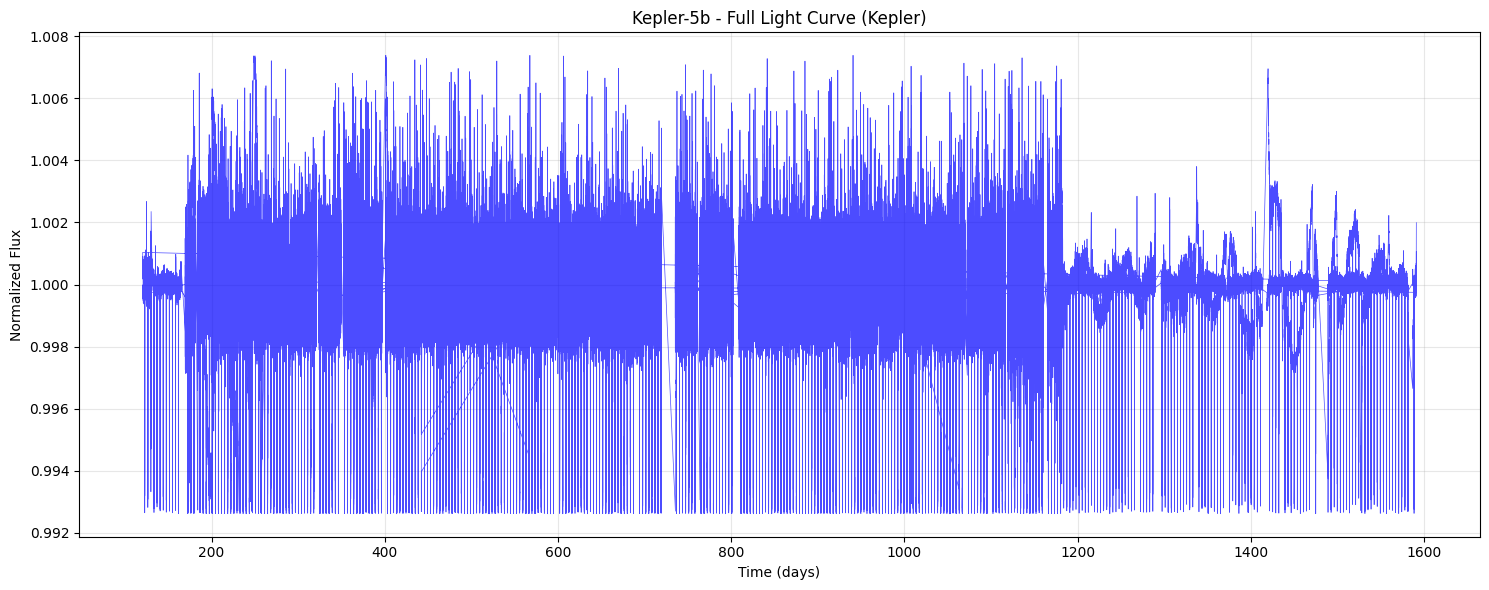

In [267]:
# Plot the full light curve
plt.figure(figsize=(15, 6))
plt.plot(lc_clean.time.value, lc_clean.flux.value, 'b-', alpha=0.7, linewidth=0.5)
plt.xlabel('Time (days)')
plt.ylabel('Normalized Flux')
plt.title(f'{TARGET} - Full Light Curve ({MISSION})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


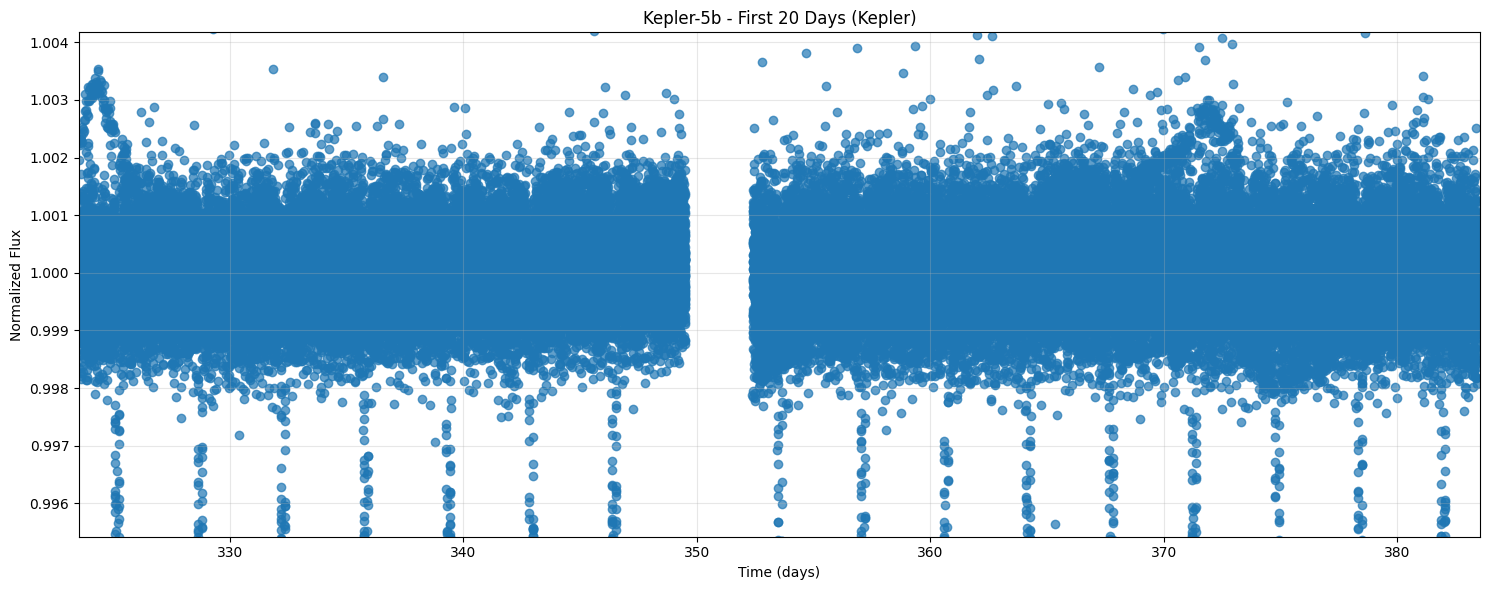

In [268]:
# Plot the full light curve
# Plot the first 20 days of the light curve
plt.figure(figsize=(15, 6))
mask = (lc_clean.time.value <= lc_clean.time.value[0] + 60)
plt.scatter(lc_clean.time.value[mask], lc_clean.flux.value[mask], alpha=0.7, linewidth=1.0)
plt.xlabel('Time (days)')
plt.ylabel('Normalized Flux')
plt.title(f'{TARGET} - First 20 Days ({MISSION})')
plt.xlim(lc_clean.time.value[0], lc_clean.time.value[0] + 60)
# Set y-axis limits to zoom in around the data
y_data = lc_clean.flux.value[mask]
y_mean = np.mean(y_data)
y_std = np.std(y_data)
plt.ylim(y_mean - 3*y_std, y_mean + 3*y_std)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Section 5. Feature extraction

In [272]:
# Extract features using the pipeline
print("Extracting features...")
feats = extract_all_features_v3(lc)
print("\nFeature extraction completed!")


Extracting features...
Starting feature extraction from arrays...
Data loaded: 1,505,069 valid points
Time range: 120.54 to 1591.00 days
Flux range: 0.978382 to 1.212733
Starting BLS detrending and period search...
Pre-BLS stitching: 135 segments, winsor 0.3% per segment
BLS input: 1,505,069 valid points
Masked eclipses: 4,241 points | depth med=0.00756
Period search range: 0.500 to 200.000 days
Duration search range: 0.0100 to 0.1000 days
Search grid: 2000 periods × 50 durations = 100,000 combinations
Computing BLS periodogram...
BLS periodogram computed successfully
Initial BLS result: P=7.0951 days, T14=0.1000 days, t0=126.59
Starting period/duration refinement...
Running period de-aliasing...
De-alias selected P=3.548352 (from 7.096793), epochs=414
Transit mask created: 84,381 transit points, 1,420,688 out-of-transit points
Starting iterative spline detrending...
Spline iteration 1: 1,416,321 points used for fitting
Spline iteration 2: 1,416,259 points used for fitting
Spline itera

In [270]:
# Display extracted features
print("\n=== EXTRACTED FEATURES ===")
for key, value in feats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.6f}")
    else:
        print(f"{key}: {value}")



=== EXTRACTED FEATURES ===
period_days: 3.548352
t0: 122.919410
duration_days: 0.197502
duration_hours: 4.740051
scale_mean: -0.161402
scale_std: 1.000000
scale_skewness: 1.550821
scale_kurtosis: 415.256123
scale_outlier_resistance: 0.140126
local_noise: 0.000661
depth_stability: 0.199808
acf_lag_1h: 0.556206
acf_lag_3h: 0.146439
acf_lag_6h: -0.030333
acf_lag_12h: -0.035559
acf_lag_24h: -0.030376
cadence_hours: 0.016347
depth_mean_per_transit: 0.007435
depth_std_per_transit: 0.000922
npts_transit_median: 1224.000000
cdpp_3h: 980.011743
cdpp_6h: 1135.706201
cdpp_12h: 1434.746630
SES_mean: 6.946272
SES_std: 0.861649
MES: 138.229239
snr_global: 6.946272
snr_per_transit_mean: 6.946272
snr_per_transit_std: 0.861649
resid_rms_global: 0.001667
vshape_metric: 0.951404
secondary_depth: 0.001130
secondary_depth_snr: 847.084716
secondary_depth_snr_log10: 0.313034
secondary_depth_snr_capped: 1.056050
secondary_to_primary_ratio: 0.152031
secondary_is_eb_like: False
odd_even_depth_ratio: 1.000175
i

## Section 6. Feature saving

In [273]:
current_date = datetime.datetime.now().strftime("%Y%m%d")

output_dir = "./data/feature_results"
os.makedirs(output_dir, exist_ok=True)

filename = f"{TARGET}_{current_date}.csv"
output_path = os.path.join(output_dir, filename)

df = pd.DataFrame([feats])
df.to_csv(output_path, index=False)

print(f"Features saved to: {output_path}")
print(f"Total features: {len(feats)}")
print(f"File size: {os.path.getsize(output_path) / 1024:.2f} KB")

Features saved to: ./data/feature_results/Kepler-5b_20251005.csv
Total features: 44
File size: 1.46 KB


## Section 7. Data plotting


Detected period: 6.2819 days
Transit epoch: 122.6297 days


ValueError: not enough values to unpack (expected 3, got 2)

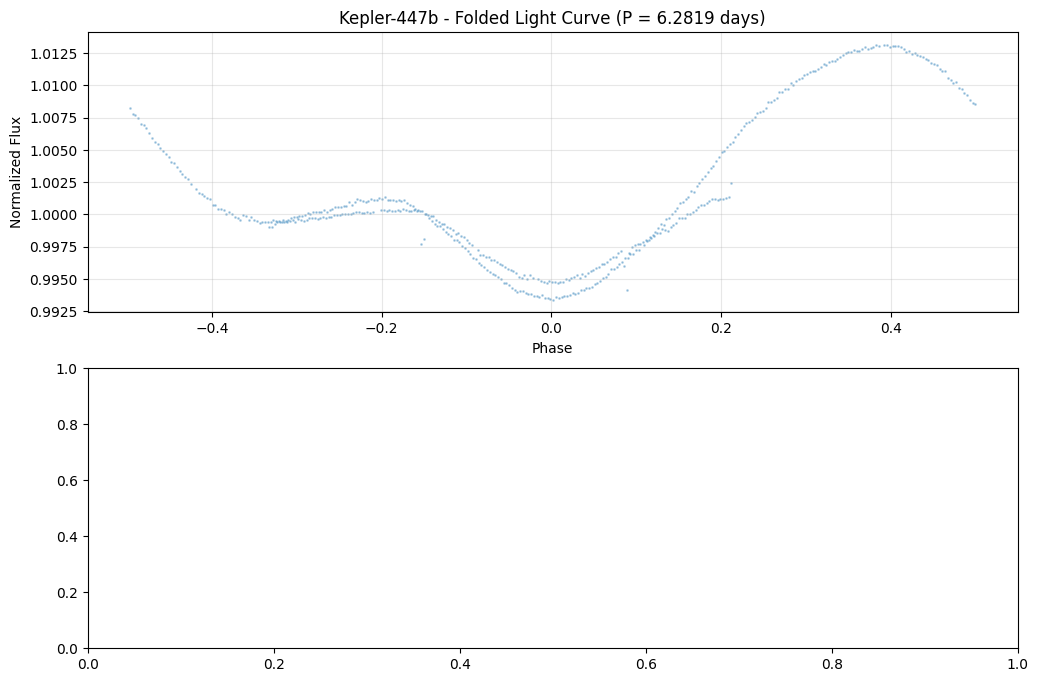

In [ ]:
# Plot folded light curve if period was detected
period = feats.get('period_days', np.nan)
t0 = feats.get('t0', np.nan)

if np.isfinite(period) and np.isfinite(t0):
    print(f"\nDetected period: {period:.4f} days")
    print(f"Transit epoch: {t0:.4f} days")
    
    # Fold the light curve
    phase = ((lc_clean.time.value - t0) / period) % 1.0
    phase = (phase + 0.5) % 1.0 - 0.5
    
    plt.figure(figsize=(12, 8))
    
    # Plot folded light curve
    plt.subplot(2, 1, 1)
    plt.scatter(phase, lc_clean.flux.value, alpha=0.3, s=1)
    plt.xlabel('Phase')
    plt.ylabel('Normalized Flux')
    plt.title(f'{TARGET} - Folded Light Curve (P = {period:.4f} days)')
    plt.grid(True, alpha=0.3)
    
    # Binned folded light curve
    plt.subplot(2, 1, 2)
    bins = np.linspace(-0.5, 0.5, 101)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    binned_flux, _, _ = np.histogram(phase, bins=bins, weights=lc_clean.flux.value)
    binned_counts, _, _ = np.histogram(phase, bins=bins)
    binned_flux = binned_flux / np.maximum(binned_counts, 1)
    
    plt.plot(bin_centers, binned_flux, 'ro-', markersize=4, linewidth=2)
    plt.xlabel('Phase')
    plt.ylabel('Binned Flux')
    plt.title('Binned Folded Light Curve')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display transit depth
    depth = feats.get('depth_mean_per_transit', np.nan)
    if np.isfinite(depth):
        print(f"Transit depth: {depth:.6f} ({depth*100:.4f}%)")
else:
    print("\nNo valid period detected - cannot fold light curve")


In [ ]:
from extract_feats import extract_all_features

data = extract_all_features("HAT-P-7", mission="Kepler")